In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/carrie1/ecommerce-data/versions/1


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data.csv to data (1).csv


In [ ]:
import pandas as pd

# Replace with the exact name of your uploaded file
da = pd.read_csv("data.csv", encoding='ISO-8859-1')

# Quick preview
da.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
#Data Cleaning
#Data Cleaning
# Drop rows without CustomerID
da = da.dropna(subset=['CustomerID'])

# Remove cancelled invoices (those starting with 'C')
da = da[~da['InvoiceNo'].astype(str).str.startswith('C')].copy()

# Convert InvoiceDate to datetime
da['InvoiceDate'] = pd.to_datetime(da['InvoiceDate'])

# Create TotalPrice column safely
da.loc[:, 'TotalPrice'] = da['Quantity'] * da['UnitPrice']

# Remove negative quantity/price
da = da[(da['Quantity'] > 0) & (da['UnitPrice'] > 0)].copy()

In [ ]:
#EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('ggplot')

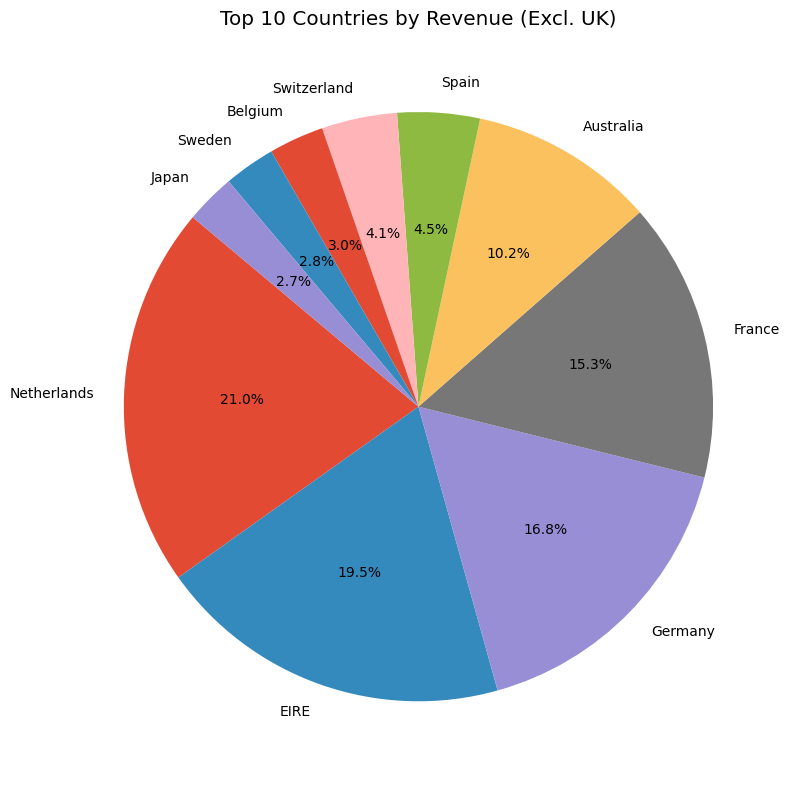

In [ ]:
# Total Revenue
country_revenue = da.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
country_revenue = country_revenue.drop('United Kingdom').head(10)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_revenue, labels=country_revenue.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Countries by Revenue (Excl. UK)")
plt.axis('equal')  # Equal aspect ratio ensures the pie is round
plt.tight_layout()
plt.show()

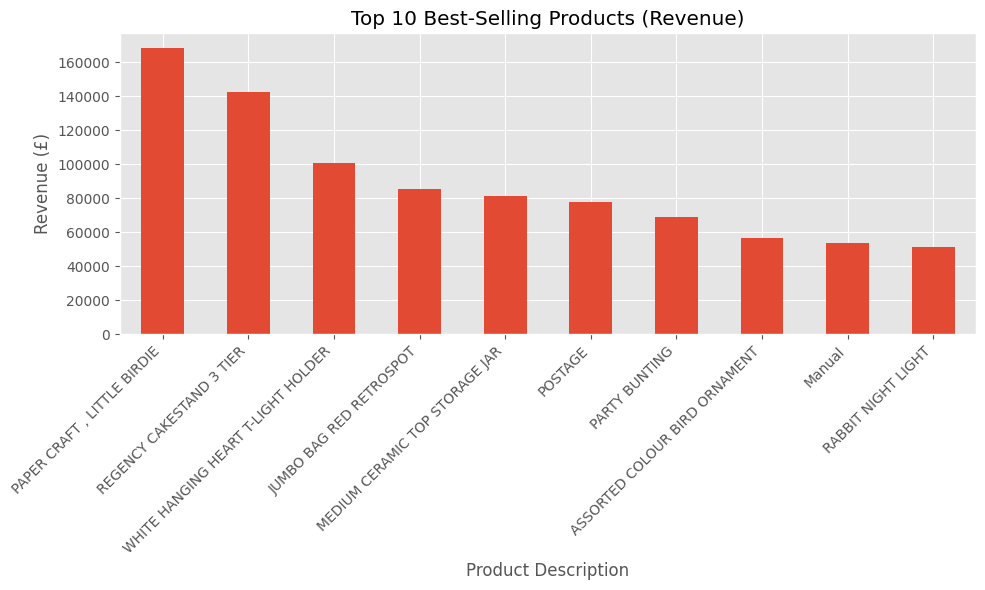

In [ ]:
#Top 10 Best-Selling Products (by revenue)

top_products = da.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title("Top 10 Best-Selling Products (Revenue)")
plt.ylabel("Revenue (£)")
plt.xlabel("Product Description")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-76-9cdf6a1af23e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




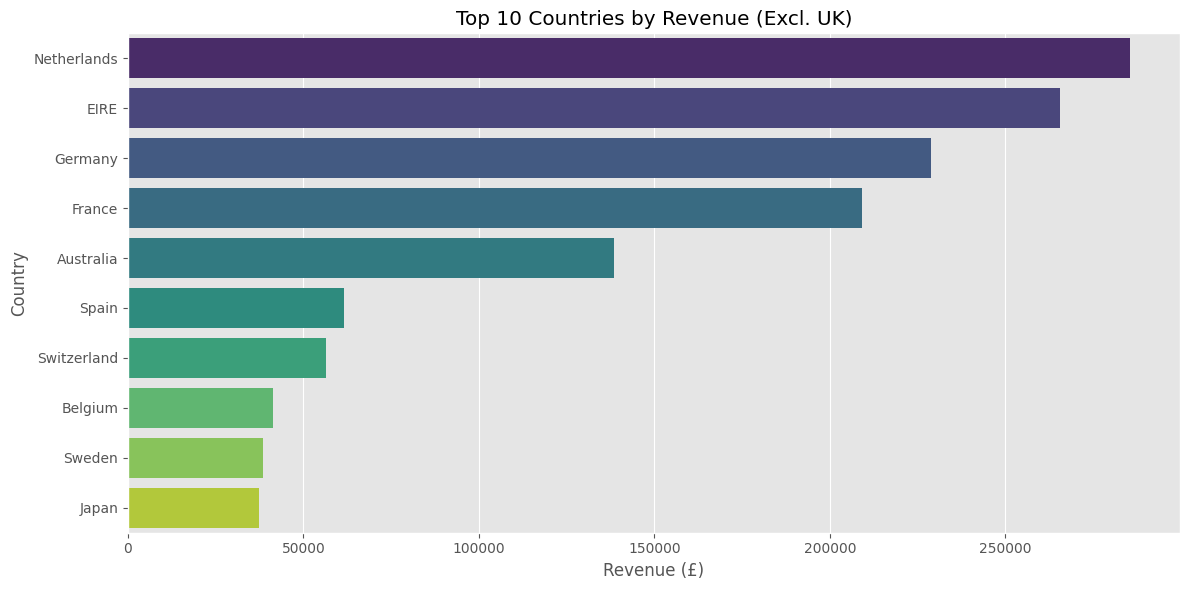

In [ ]:
#Revenue By Country
country_revenue = da.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).drop('United Kingdom').head(10)
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette="viridis")
plt.title("Top 10 Countries by Revenue (Excl. UK)")
plt.xlabel("Revenue (£)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [ ]:
#Sales By Hour
import plotly.express as px

# Group revenue by hour
da['Hour'] = da['InvoiceDate'].dt.hour
hourly_sales = da.groupby('Hour')['TotalPrice'].sum().reset_index()

# Plotly interactive bar chart
fig = px.bar(
    hourly_sales,
    x='Hour',
    y='TotalPrice',
    labels={'TotalPrice': 'Revenue (£)', 'Hour': 'Hour of Day'},
    title='Interactive: Revenue by Hour of Day'
)

fig.update_layout(xaxis=dict(dtick=1))  # Ensure each hour shows up on X-axis
fig.show()

In [ ]:
#RFM ANALYSIS
# Reference date (e.g., the day after the last transaction)
import datetime as dt

snapshot_date = da['InvoiceDate'].max() + dt.timedelta(days=1)

In [ ]:
rfm = da.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
# Recency: Lower is better
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency & Monetary: Higher is better
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [ ]:
# Combine RFM scores
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Quick look at segments
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,7,4310.00,5,5,5,555
12348.0,75,4,1797.24,2,4,4,244
12349.0,19,1,1757.55,4,1,4,414
12350.0,310,1,334.40,1,1,2,112


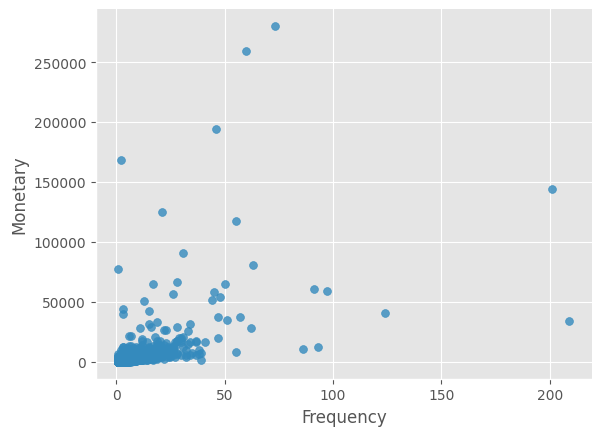

In [ ]:
# @title Frequency vs Monetary

from matplotlib import pyplot as plt
rfm.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Example segmenting logic
def rfm_segment(row):
    if row['RFM_Score'] == '555':
        return 'Best Customers'
    elif row['R'] == '5':
        return 'Recent Customers'
    elif row['F'] == '5':
        return 'Frequent Buyers'
    elif row['M'] == '5':
        return 'Big Spenders'
    elif row['R'] == '1':
        return 'Churn Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

# View counts by segment
rfm['Segment'].value_counts()


,count
Segment,
Others,3990
Best Customers,348


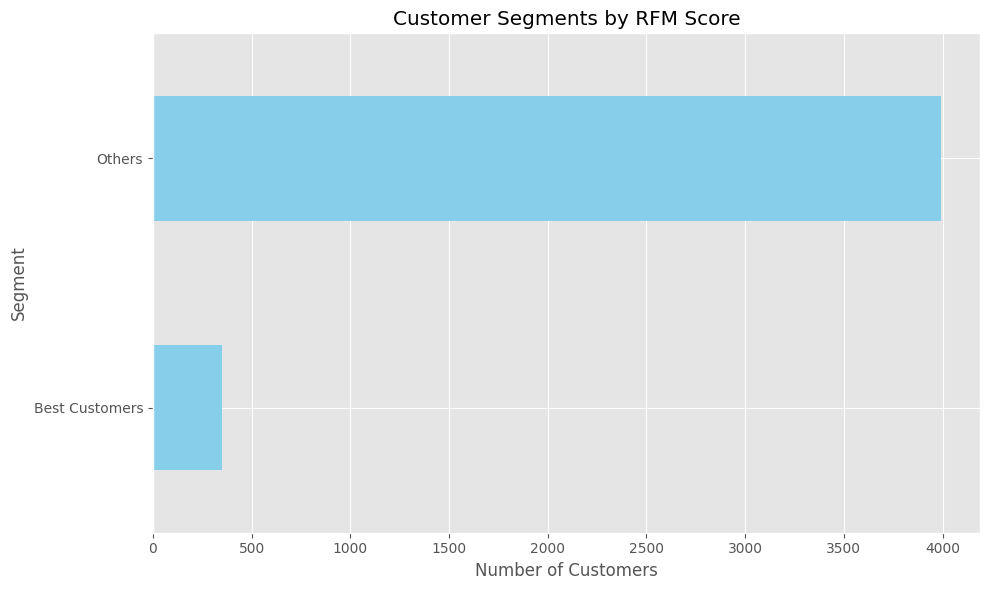

In [ ]:
plt.figure(figsize=(10, 6))
rfm['Segment'].value_counts().sort_values().plot(kind='barh', color='skyblue')
plt.title('Customer Segments by RFM Score')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.tight_layout()
plt.show()



In [ ]:
#Sales Forecasting with Prophet
!pip install prophet

In [ ]:
# Daily revenue
daily_revenue = da.groupby(da['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()

# Rename for Prophet
daily_revenue.columns = ['ds', 'y']  # Prophet expects 'ds' (date) and 'y' (value)

In [ ]:
from prophet import Prophet

# Initialize and fit model
model = Prophet()
model.fit(daily_revenue)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg94k9zit/ylrdjl8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg94k9zit/llbnekxh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87192', 'data', 'file=/tmp/tmpg94k9zit/ylrdjl8h.json', 'init=/tmp/tmpg94k9zit/llbnekxh.json', 'output', 'file=/tmp/tmpg94k9zit/prophet_model2g9w_tyw/prophet_model-20250327141944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


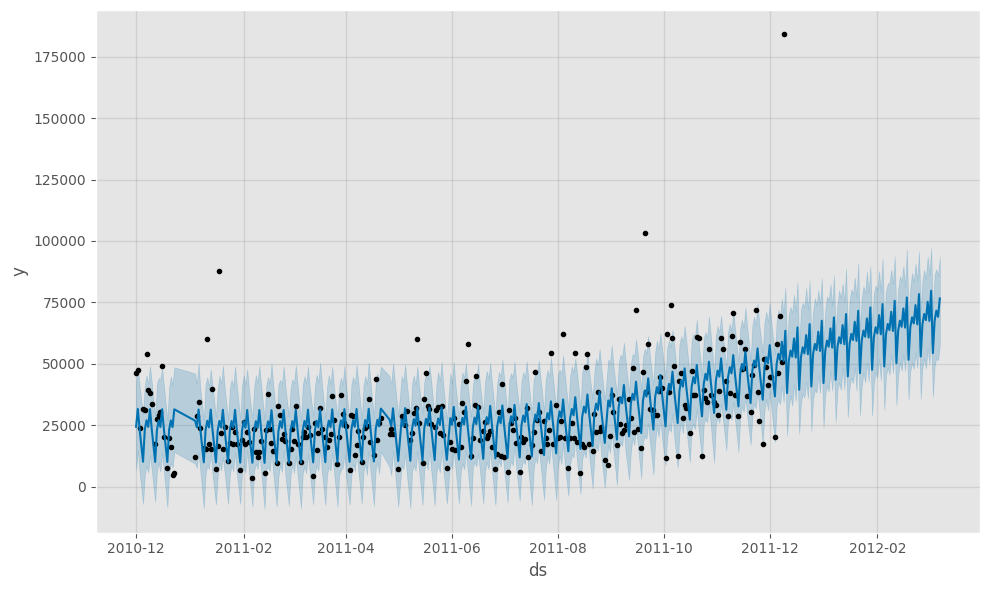

In [ ]:
# Make future dataframe (e.g., 90 days)
future = model.make_future_dataframe(periods=90)
sales_forecast = model.predict(future)

# Visualize
fig = model.plot(sales_forecast)

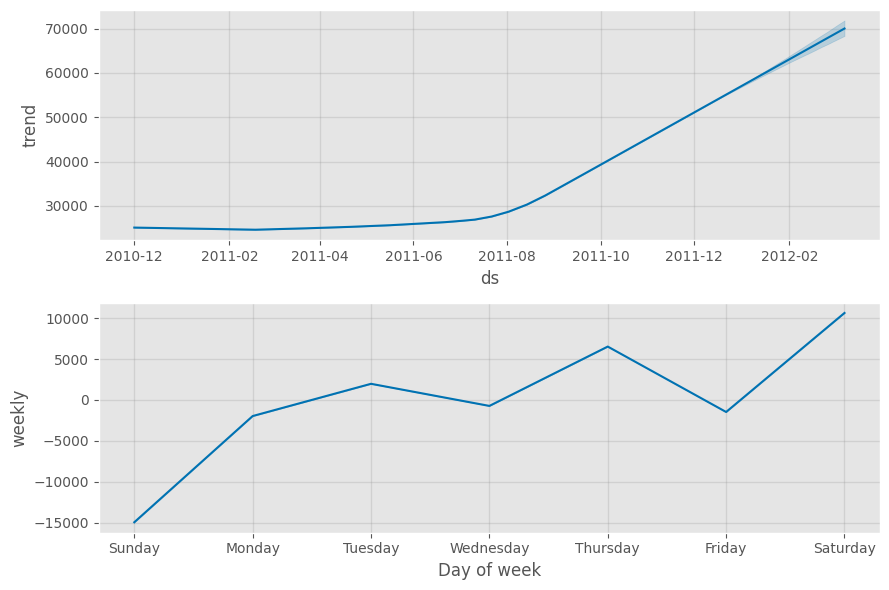

In [ ]:
fig2 = model.plot_components(sales_forecast)

In [ ]:
#Dashboard
!pip install dash

In [ ]:
daily_revenue.to_csv('actual_revenue.csv', index=False)
sales_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecasted_revenue.csv', index=False)

# Download them
from google.colab import files
files.download('actual_revenue.csv')
files.download('forecasted_revenue.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px

# Load your data
actual_da = pd.read_csv('actual_revenue.csv')
sales_forecast_da = pd.read_csv('forecasted_revenue.csv')

# Dash App Init
app = dash.Dash(__name__)
app.title = "E-Commerce Sales Dashboard"

# Layout
app.layout = html.Div(children=[
    html.H1("🛒 E-Commerce Sales Dashboard", style={'textAlign': 'center'}),

    dcc.Graph(
        id='actual-sales',
        figure=px.line(actual_da, x='ds', y='y', title='📈 Actual Revenue Over Time')
    ),

    dcc.Graph(
        id='forecasted-sales',
        figure=px.line(sales_forecast_da, x='ds', y='yhat', title='🔮 Forecasted Revenue')
    )
])

# Run Server
if __name__ == '__main__':
    app.run(debug=True) # Changed from app.run_server to app.run

<IPython.core.display.Javascript object>

In [1]:
code = """
import streamlit as st
import pandas as pd

st.title("🛒 E-Commerce Data Analysis")

data = pd.read_csv("your_data.csv")

st.subheader("Raw Dataset")
st.write(data.head())

st.subheader("Summary Statistics")
st.write(data.describe())
"""

# Save as a .py file
with open("app.py", "w") as f:
    f.write(code)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving E_Commerce_Data.ipynb to E_Commerce_Data.ipynb


In [3]:
files.download("app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>